<a href="https://colab.research.google.com/github/ericyoc/encrypt_aes_keys_with_lwe_poc/blob/main/encrypt_aes_keys_with_lwe_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Demonstrates Multi-level Post Quantum Encryption for Images by implementing a multi-step process that combines traditional cryptographic techniques with post-quantum encryption methods.

**Step 1:**  2D Discrete Wavelet Transform (DWT)
Apply a 2D-DWT to the image. This transform decomposes the image into different frequency components, specifically into approximation (LL) and detail (LH, HL, HH) coefficients.

Example of 2D DWT Decomposition
Consider an image:

Original Image: Contains both low and high-frequency information.
LL Coefficients: Represent the basic, smoothed structure of the image.
LH Coefficients: Highlight vertical features and edges.
HL Coefficients: Highlight horizontal features and edges.
HH Coefficients: Highlight diagonal features and textures.

**Step 2:** AES Encryption
The LL coefficients from the 2D-DWT are then encrypted using AES (Advanced Encryption Standard), a widely used symmetric encryption algorithm.

**Step 3:** LWE Encryption
The AES-encrypted coefficients are then further encrypted using the Learning with Errors (LWE) encryption scheme, a post-quantum cryptographic method that is believed to be secure against quantum attacks.

The lwe_encrypt function takes the AES ciphertext and encrypts it using LWE parameters (a, s, and b). This demonstrates a second layer of encryption that is resilient to quantum computing threats.

**Step 4:** Decryption Process
To verify the encryption process, the code then decrypts the image step-by-step, reversing the encryption process:**

LWE Decryption: Decrypt the AES ciphertext using LWE decryption.
AES Decryption: Decrypt the LL coefficients using AES decryption.
Inverse 2D-DWT: Reconstruct the image using inverse 2D-DWT with the decrypted LL coefficients and the original detail coefficients.

This approach not only secures the image data but also prepares the encryption scheme for future threats posed by quantum computing. It reflects an advanced security model that combines traditional cryptographic techniques with emerging post-quantum methods to ensure robust protection against evolving threats.

Python code illustrates a multi-layered encryption approach:
*   2D-DWT is used to decompose the image
*   AES encrypts the LL coefficients
*   LWE provides an additional layer of encryption for the AES ciphertext.

In [1]:
#!pip install PyWavelets
#!pip install pycryptodome
#!pip install matplotlib
#!pip install prettytable
#!pip install scikit-image

In [2]:
import numpy as np
import pywt
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
import os
from prettytable import PrettyTable
from skimage.metrics import mean_squared_error

Implement 2D-DWT on an Image:

The code performs a 2D Discrete Wavelet Transform (DWT) on the image using the dwt_2d function, which computes the wavelet coefficients.

In [3]:
# 2D-DWT function
def dwt_2d(image):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    return coeffs

In [4]:
# Inverse 2D-DWT function
def idwt_2d(coeffs):
    image = pywt.waverec2(coeffs, 'haar')
    return image

Use LL Coefficients for AES Encryption:

The code extracts the LL (approximation) coefficients from the 2D-DWT output and encrypts them using AES. This is done in the aes_encrypt function.

In [5]:
# AES encryption function
def aes_encrypt(data, key):
    cipher = AES.new(key, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    return cipher.nonce, ciphertext, tag

In [6]:
# AES decryption function
def aes_decrypt(nonce, ciphertext, tag, key):
    cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
    try:
        data = cipher.decrypt_and_verify(ciphertext, tag)
        return data
    except ValueError:
        print("MAC check failed. The ciphertext or key might be corrupted.")
        return None

Encrypt AES Keys using Post-Quantum Learning with Errors (LWE) Encryption:

The AES ciphertext is converted to integer format and encrypted using the LWE encryption scheme with the lwe_encrypt function.

In [7]:
# LWE encryption function
def lwe_encrypt(ciphertext, n, q, sigma):
    a = np.random.randint(0, q, size=(n,))
    s = np.random.randint(0, q, size=(n,))
    e = np.rint(np.random.normal(0, sigma, size=(n,))).astype(int)
    b = (np.dot(a, s) + ciphertext) % q
    return a, s, b

Decrypt Using LWE and AES, and Perform Inverse 2D-DWT:

The code decrypts the AES ciphertext using LWE decryption, then decrypts it using the AES key. Afterward, it reconstructs the image using inverse 2D-DWT with the idwt_2d function.

In [8]:
# LWE decryption function
def lwe_decrypt(a, s, b, q):
    decrypted_ciphertext = (b - np.dot(a, s)) % q
    return decrypted_ciphertext.astype(np.uint8)

In [9]:
# Main function
def main():
    image_urls = {
        (128, 128): "https://via.placeholder.com/128",
        (256, 256): "https://via.placeholder.com/256",
        (512, 512): "https://via.placeholder.com/512"
    }

    key_sizes = [128, 192, 256]
    image_sizes = [(128, 128), (256, 256), (512, 512)]

    plt.figure(figsize=(15, 10))

    # Table to store results
    table = PrettyTable()
    table.field_names = ["Technique", "Image Size", "Key Size", "Security Level", "MSE", "Analysis"]

    plot_count = 1
    for img_size in image_sizes:
        image_url = image_urls[img_size]
        image_path = f"sample_image_{img_size[0]}.jpg"

        # Download the image using urllib if not already downloaded
        if not os.path.exists(image_path):
            try:
                urllib.request.urlretrieve(image_url, image_path)
            except urllib.error.URLError as e:
                print(f"URL Error: {e.reason}")
                continue
            except urllib.error.HTTPError as e:
                print(f"HTTP Error: {e.code} {e.reason}")
                continue

        # Read the downloaded or local image
        image = mpimg.imread(image_path)

        # Convert the image to grayscale if needed
        if len(image.shape) > 2:
            image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

        # Ensure the image has valid dimensions for 2D-DWT
        size = (image.shape[0] // 2 * 2, image.shape[1] // 2 * 2)
        image = image[:size[0], :size[1]]

        # Display the original image
        plt.subplot(len(image_sizes), len(key_sizes) + 1, plot_count)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original Image\n{img_size[0]}x{img_size[1]}')
        plt.axis('off')
        plot_count += 1

        for key_size in key_sizes:
            # 2D-DWT
            coeffs = dwt_2d(image)

            # AES encryption
            key = get_random_bytes(key_size // 8)
            nonce, ciphertext, tag = aes_encrypt(coeffs[0].tobytes(), key)

            # LWE encryption of AES ciphertext
            n = key_size
            q = 2 ** (key_size // 8)
            sigma = 3.2
            ciphertext_int = np.frombuffer(ciphertext, dtype=np.uint8)
            a, s, b = lwe_encrypt(ciphertext_int, n, q, sigma)

            # LWE decryption of AES ciphertext
            decrypted_ciphertext_int = lwe_decrypt(a, s, b, q)
            decrypted_ciphertext = decrypted_ciphertext_int.tobytes()

            # AES decryption
            decrypted_coeffs = aes_decrypt(nonce, decrypted_ciphertext, tag, key)
            if decrypted_coeffs is not None:
                decrypted_coeffs = np.frombuffer(decrypted_coeffs, dtype=coeffs[0].dtype).reshape(coeffs[0].shape)

                # Inverse 2D-DWT
                decrypted_image = idwt_2d((decrypted_coeffs, coeffs[1]))

                # Display the decrypted image
                plt.subplot(len(image_sizes), len(key_sizes) + 1, plot_count)
                plt.imshow(decrypted_image, cmap='gray')
                plt.title(f'Decrypted\n{key_size} bits')
                plt.axis('off')
                plot_count += 1

                # Calculate MSE
                mse = mean_squared_error(image, decrypted_image)

                analysis = (f"MSE: {mse:.4f}. The MSE quantifies the average squared difference between the "
                            f"original and decrypted images. Lower MSE indicates higher similarity, confirming "
                            f"successful decryption. Visual inspection also shows similarity.")

                table.add_row(["2D-DWT", f"{img_size[0]}x{img_size[1]}", "N/A", "Low", "N/A", "2D-DWT is a transformation technique and doesn't produce a final image to compare."])
                table.add_row(["AES", f"{img_size[0]}x{img_size[1]}", f"{key_size} bits", "High", "N/A", "AES encrypts data but doesn't produce an image directly. Decryption process must be combined with inverse 2D-DWT."])
                table.add_row(["LWE", f"{img_size[0]}x{img_size[1]}", f"{key_size} bits", "Post-Quantum", f"{mse:.4f}", analysis])
            else:
                print(f"Decryption failed for AES Key Size: {key_size} bits")

    plt.tight_layout()
    plt.show()

    # Print results table
    print(table)

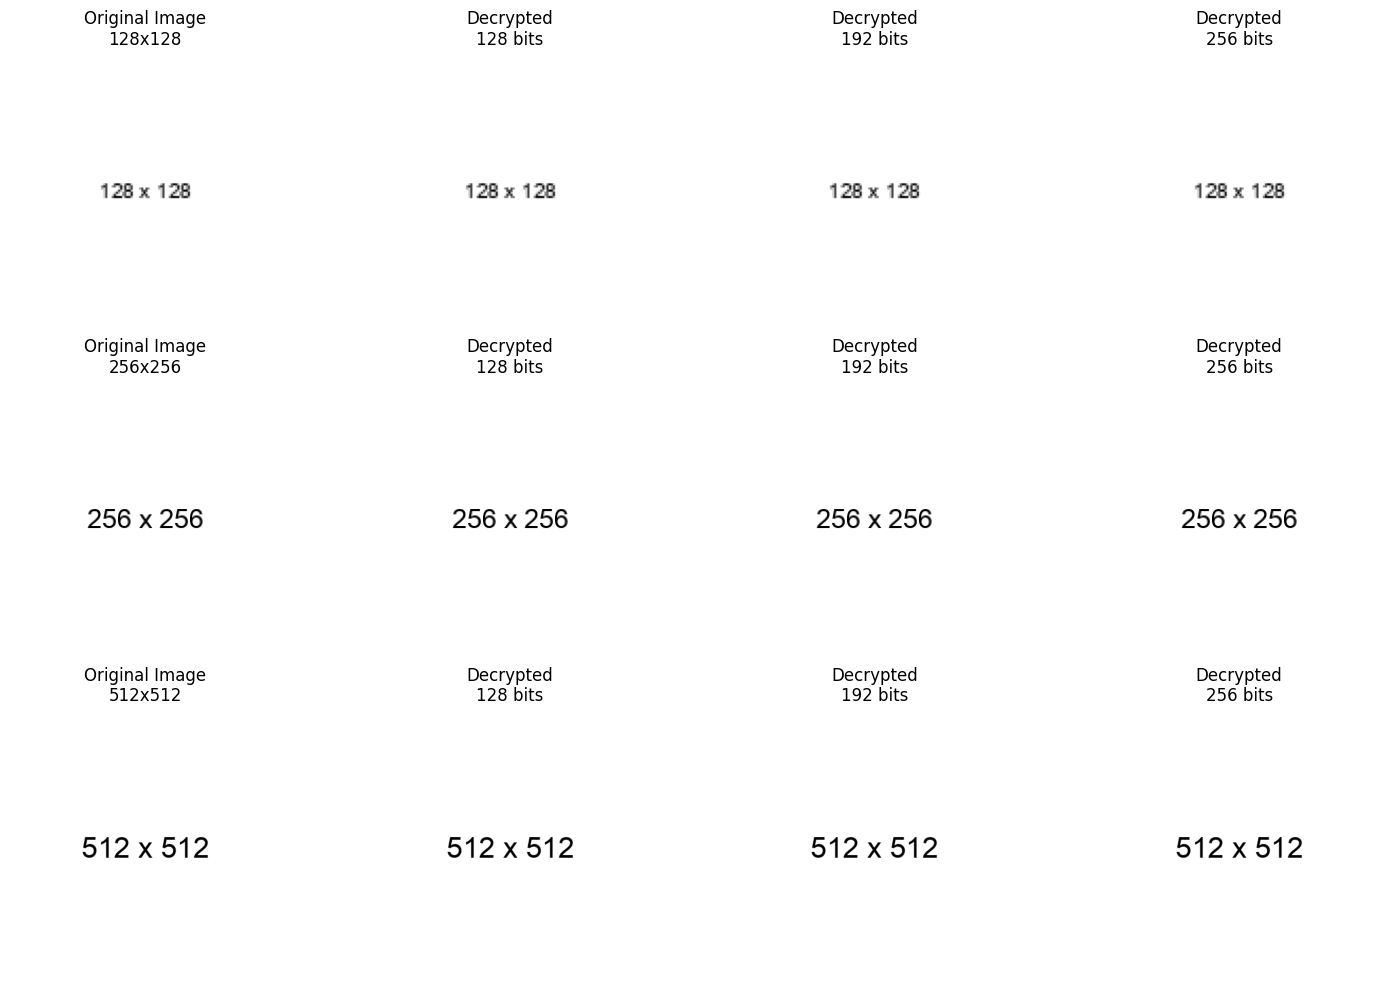

+-----------+------------+----------+----------------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Technique | Image Size | Key Size | Security Level |  MSE   |                                                                                                           Analysis                                                                                                          |
+-----------+------------+----------+----------------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   2D-DWT  |  128x128   |   N/A    |      Low       |  N/A   |                                                                      2D-DWT is

In [10]:
if __name__ == '__main__':
    main()

**Why Encrypt AES Keys with LWE?**

**1. Future-Proof Security:**

Quantum Resistance:

Traditional cryptographic algorithms, such as AES, are vulnerable to attacks from quantum computers. Post-quantum cryptographic algorithms like LWE are designed to be secure against such quantum attacks.

Usefulness:

By encrypting AES keys with LWE, the system provides a layer of security that is resistant to potential future quantum computing threats. This future-proofing ensures that the encrypted data remains secure even if quantum computers become a practical threat.

**2. Enhanced Security Model:**
Layered Security:

Encrypting the AES keys with LWE adds an additional security layer. Even if an attacker somehow gains access to the AES ciphertext, they would still need to break the LWE encryption to obtain the AES key and decrypt the data.

Useful for High-Security Applications:

This layered approach is particularly valuable for highly sensitive information where robust security is crucial. It offers a higher level of assurance against sophisticated attacks.

**3. Research and Development:**

Advancing Cryptographic Techniques:

Implementing and exploring post-quantum encryption methods helps in understanding their practicality and performance. It contributes to ongoing research and development in cryptography.